In [1]:
import numpy as np
import pickle
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import stats

/home/luqman/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation

In [2]:
train_path = '/nas/project_data/B1_Behavior/hakim/FI/openface/fi_train_lld_au_bert.pkl'
val_path = '/nas/project_data/B1_Behavior/hakim/FI/openface/fi_valid_lld_au_bert.pkl'
test_path = '/nas/project_data/B1_Behavior/hakim/FI/openface/fi_test_lld_au_bert.pkl'
        
with open(train_path, 'rb') as f:
    train_data_pickle = pickle.load(f)
    train_ids, train_data, train_label = zip(*train_data_pickle)
    _, au_train, _ = zip(*train_data)
    
with open(val_path, 'rb') as f:
    val_data_pickle = pickle.load(f)
    val_ids, val_data, val_label = zip(*val_data_pickle)
    _, au_val, _ = zip(*val_data)
    
with open(test_path, 'rb') as f:
    test_data_pickle = pickle.load(f)
    test_ids, test_data, test_label = zip(*test_data_pickle)
    _, au_test, _ = zip(*test_data)

with open('/home/luqman/linear_mult/linear_mult/mean_std_fi.pkl', 'rb') as f:
    mean_std = pickle.load(f)
    
train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []

In [3]:
for i, id in enumerate(train_ids):
    label = train_label[i]
    au = (au_train[i] - mean_std[1][0]) / mean_std[1][1]
#     padding to 450x35
    if au.shape[0] < 450:
        au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    else:
        au = au[:450,:]
#         include only several AU
    au = np.concatenate((au[:,17:20], au[:,21:23], au[:,24:29], au[:,30:31]), axis=1)
    train_features.append(au)
    train_labels.append(label)
    
for i, id in enumerate(val_ids):
    label = train_label[i]
    au = (au_val[i] - mean_std[1][0]) / mean_std[1][1]
    if au.shape[0] < 450:
        au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    else:
        au = au[:450,:]
    #         include only several AU
    au = np.concatenate((au[:,17:20], au[:,21:23], au[:,24:29], au[:,30:31]), axis=1)
    val_features.append(au)
    val_labels.append(label)
    
for i, id in enumerate(test_ids):
    label = train_label[i]
    au = (au_test[i] - mean_std[1][0]) / mean_std[1][1]
    if au.shape[0] < 450:
        au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    else:
        au = au[:450,:]
    #         include only several AU
    au = np.concatenate((au[:,17:20], au[:,21:23], au[:,24:29], au[:,30:31]), axis=1)
    test_features.append(au)
    test_labels.append(label)

In [4]:
train_features = torch.Tensor(np.array(train_features))
train_labels = torch.Tensor(np.array(train_labels))
val_features = torch.Tensor(np.array(val_features))
val_labels = torch.Tensor(np.array(val_labels))
test_features = torch.Tensor(np.array(test_features))
test_labels = torch.Tensor(np.array(test_labels))

BATCH_SIZE = 256
train_ds = TensorDataset(train_features, train_labels)
val_ds = TensorDataset(val_features, val_labels)
test_ds = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [6]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional, output_dim, dropout, num_layers, batch_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = dropout
        self.gru = torch.nn.GRU(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                dropout=self.dropout,
                                bidirectional=bidirectional,
                                batch_first=True)
        self.fc = torch.nn.Linear(hidden_size if not bidirectional else hidden_size * 2, output_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out, h = self.gru(x)
        out = self.relu(out[:,-1,:])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Training

In [7]:
def train(model, train_loader, val_loader, epochs, patience=5):
    train_losses = []
    val_losses = []
    val_maes = []
    last_loss = 0.000001
    trigger_times = 0

    for epoch in range(0, epochs):
        model.train()
        batch_losses = []

        for inputs, targets in train_loader:
            preds = model(inputs.to(device))
            loss = loss_fn(preds, targets.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            batch_val_losses = []
            batch_val_mae = []

            for inputs, targets in val_loader:
                model.eval()
                preds = model(inputs.to(device))
                loss = loss_fn(preds, targets.to(device))
                batch_val_losses.append(loss.item())
                val_mae = mae(preds, targets.to(device))
                batch_val_mae.append(val_mae.item())
            
            val_loss = np.mean(batch_val_losses)
            val_mae = np.mean(batch_val_mae)
            scheduler.step(val_loss)
            val_losses.append(val_loss)
            val_maes.append(val_mae)
  
        print(f'Epoch {epoch} - train loss: {train_loss:.4f} - val loss: {val_loss:.4f} - val 1-mae: {(1-val_mae):.4f}')
        
        if val_loss > last_loss:
            trigger_times += 1
            print('Trigger:', trigger_times)
            if trigger_times >= patience:
                print('Early stop')
                break
        else:
            print('Trigger: 0')
            trigger_times = 0
        last_loss = val_loss
        
    return train_losses, val_losses, val_maes

In [19]:
model = GRU(input_size=11, 
                  hidden_size=128, 
                  bidirectional=True, 
                  output_dim=5, 
                  dropout=0.3, 
                  num_layers=2, 
                  batch_size=BATCH_SIZE)
model.to(device)


LR = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

In [20]:
train_losses, val_losses, val_maes = train(model, train_loader, val_loader, epochs=50, patience=5)

Epoch 0 - train loss: 0.0235 - val loss: 0.0237 - val 1-mae: 0.8759
Trigger: 1
Epoch 1 - train loss: 0.0233 - val loss: 0.0236 - val 1-mae: 0.8762
Trigger: 0
Epoch 2 - train loss: 0.0232 - val loss: 0.0236 - val 1-mae: 0.8762
Trigger: 0
Epoch 3 - train loss: 0.0231 - val loss: 0.0235 - val 1-mae: 0.8765
Trigger: 0
Epoch 4 - train loss: 0.0230 - val loss: 0.0234 - val 1-mae: 0.8769
Trigger: 0
Epoch 5 - train loss: 0.0229 - val loss: 0.0233 - val 1-mae: 0.8771
Trigger: 0
Epoch 6 - train loss: 0.0228 - val loss: 0.0233 - val 1-mae: 0.8773
Trigger: 0
Epoch 7 - train loss: 0.0228 - val loss: 0.0233 - val 1-mae: 0.8774
Trigger: 0
Epoch 8 - train loss: 0.0226 - val loss: 0.0232 - val 1-mae: 0.8775
Trigger: 0
Epoch 9 - train loss: 0.0226 - val loss: 0.0232 - val 1-mae: 0.8777
Trigger: 0
Epoch 10 - train loss: 0.0225 - val loss: 0.0232 - val 1-mae: 0.8777
Trigger: 1
Epoch 11 - train loss: 0.0224 - val loss: 0.0231 - val 1-mae: 0.8778
Trigger: 0
Epoch 12 - train loss: 0.0223 - val loss: 0.0230 -

# Plot

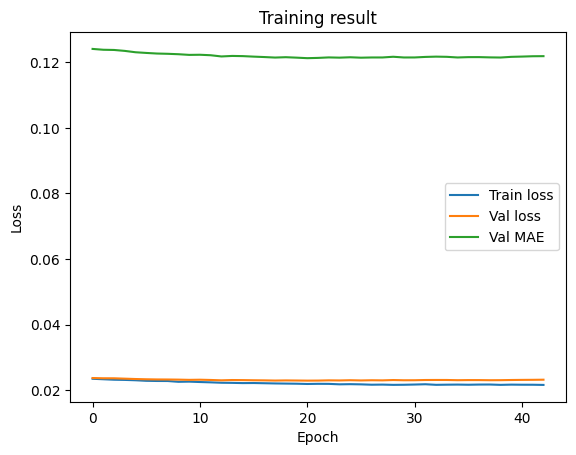

In [21]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Val loss')
ax.plot(val_maes, label='Val MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title("Training result")
plt.legend()

# Testing

In [22]:
def test(model, test_loader):
    mae = torch.nn.L1Loss()
    predictions = np.array([])
    labels = np.array([])
    model.eval()
    with torch.no_grad():
        batch_loss_ext = []
        batch_loss_neu = []
        batch_loss_agr = []
        batch_loss_con = []
        batch_loss_ope = []

        for inputs, targets in test_loader:
            batch_preds = model(inputs.to(device))
            loss_ext = mae(batch_preds[:,0], targets[:,0].to(device))
            loss_neu = mae(batch_preds[:,1], targets[:,1].to(device))
            loss_agr = mae(batch_preds[:,2], targets[:,2].to(device))
            loss_con = mae(batch_preds[:,3], targets[:,3].to(device))
            loss_ope = mae(batch_preds[:,4], targets[:,4].to(device))
            batch_loss_ext.append(loss_ext.item())
            batch_loss_neu.append(loss_neu.item())
            batch_loss_agr.append(loss_agr.item())
            batch_loss_con.append(loss_con.item())
            batch_loss_ope.append(loss_ope.item())
            predictions = np.vstack((predictions, batch_preds.cpu())) if len(predictions) != 0 else batch_preds.cpu()
            labels = np.vstack((labels, targets.cpu())) if len(labels) != 0 else targets.cpu()

        loss_ext = 1 - np.mean(batch_loss_ext)
        loss_neu = 1 - np.mean(batch_loss_neu)
        loss_agr = 1 - np.mean(batch_loss_agr)
        loss_con = 1 - np.mean(batch_loss_con)
        loss_ope = 1 - np.mean(batch_loss_ope)
        loss = (loss_ext + loss_neu + loss_agr + loss_con + loss_ope) / 5

        print(f'1-MAE: {loss:.4f}')
        print(f'1-MAE O: {loss_ope:.4f}')
        print(f'1-MAE C: {loss_con:.4f}')
        print(f'1-MAE E: {loss_ext:.4f}')
        print(f'1-MAE A: {loss_agr:.4f}')
        print(f'1-MAE N: {loss_neu:.4f}')
        
        spearman_r_ext = stats.spearmanr(predictions[:,0], labels[:,0])
        spearman_r_neu = stats.spearmanr(predictions[:,1], labels[:,1])
        spearman_r_agr = stats.spearmanr(predictions[:,2], labels[:,2])
        spearman_r_con = stats.spearmanr(predictions[:,3], labels[:,3])
        spearman_r_ope = stats.spearmanr(predictions[:,4], labels[:,4])
        print(f'O - R: {spearman_r_ope[0]:.3f} - p: {spearman_r_ope[1]:.3f}')
        print(f'C - R: {spearman_r_con[0]:.3f} - p: {spearman_r_con[1]:.3f}')
        print(f'E - R: {spearman_r_ext[0]:.3f} - p: {spearman_r_ext[1]:.3f}')
        print(f'A - R: {spearman_r_agr[0]:.3f} - p: {spearman_r_agr[1]:.3f}')
        print(f'N - R: {spearman_r_neu[0]:.3f} - p: {spearman_r_neu[1]:.3f}')

In [23]:
test(model, test_loader)

1-MAE: 0.8784
1-MAE O: 0.8743
1-MAE C: 0.8895
1-MAE E: 0.8829
1-MAE A: 0.8739
1-MAE N: 0.8712
O - R: 0.012 - p: 0.596
C - R: -0.009 - p: 0.692
E - R: -0.010 - p: 0.653
A - R: 0.004 - p: 0.875
N - R: -0.019 - p: 0.397


In [18]:
prior = test_labels.mean(axis=0)
test_prior = torch.from_numpy(np.repeat(np.expand_dims(prior, axis=0), 2000, axis=0))
value = mae(test_prior, test_labels)
print('baseline prior 1-mae:', 1-value.item())

baseline prior 1-mae: 0.8791207298636436
